[한국어와 NLTK, Gensim의 만남 by Lucy Park](https://www.lucypark.kr/docs/2015-pyconkr/#43)  
아래 내용은 상기 링크를 정리한것.

# 감성분석 (feat. KoNLPy)

## Data preprocessing

In [1]:
def read_data(filename):
    with open(filename, 'r', encoding='utf-8') as f:
        data = [line.split('\t') for line in f.read().splitlines()]
        data = data[1:] # header 제외 변수
    return data

def tag_writing_data(filename):
    open(filename, 'w', encoding='utf-8')


train_data = read_data('ratings_train.txt')
test_data = read_data('ratings_test.txt')

제대로 읽혔는지 확인

In [2]:
print("train")
print(len(train_data))
print(len(train_data[0]))
print("test")
print(len(test_data))
print(len(test_data[0]))

train
150000
3
test
50000
3


형태소로 토크나이징

In [7]:
from konlpy.tag import Twitter
pos_tagger = Twitter()

def tokenize(doc):
    # norm, stem은 optional
    return ['/'.join(t) for t in pos_tagger.pos(doc, norm=True, stem=True)]
"""
row[0] : id
row[1] : document
row[2] : label
for row in train_data:
    print("id : ",row[0])
    print("document : ", row[1])
    print("label : ", row[2])
"""

train_docs = [(tokenize(row[1]), row[2]) for row in train_data]
test_docs = [(tokenize(row[1]), row[2]) for row in test_data]

# 확인
print(train_docs[0])

(['아/Exclamation', '더빙/Noun', '../Punctuation', '진짜/Noun', '짜증/Noun', '나다/Verb', '목소리/Noun'], '0')


In [10]:
# # 형태소 토크나이징된 파일 저장, 로드
# import pandas as pd
# import numpy as np

# train_docs.to_csv("train_docs.txt", encoding='utf-8')
# test_docs.to_csv("test_docs.txt", encoding='utf-8')

# train_read = pd.read_csv("train_docs.csv", encoding='utf-8')
# print(train_read[0])

* 형태소로 꼭 나눠야 하는 이유
    * 데이터가 충분하면 어절 단위의 분석이 가능하지만 데이터가 적으므로 형태소를 나눠야 한다.
    * [시인 뉴럴](https://github.com/carpedm20/poet-neural)은 음절 단위의 분석이다.
    * 토큰의 단위는 선택의 문제
* 품사(POS) 태그를 붙여야 하는 이유
    * 선택의 문제이나 여기서는 사용
    * 품사를 태깅해두면 동음이의어를 구분할 수 있다는 장점이 있다.
        * ex '은/Josa' vs '은/Noun'

## Data exploration
* 데이터의 코퍼스가 어떤 특징들을 가지고 있는지 확인해본다.
* Training data의 token을 모은다.
* token ex) 
    * ['아/Exclamation', '더빙/Noun', '../Punctuation', '진짜/Noun', '짜증/Noun', '나다/Verb', '목소리/Noun']

In [13]:
tokens = [t for d in train_docs for t in d[0]]
print(len(tokens))

2194536


* nltk.Text()를 써본다. (Exploration이 편하다)
    * 원래 단일 document를 분석할 때는 훨씬 풍부한 기능들을 사용할 수 있지만, 여기서는 그 중 몇 가지만 살펴본다.

In [29]:
import nltk
text = nltk.Text(tokens, name = 'NMSC')
print(text)

<Text: NMSC>


In [16]:
print(len(text.tokens)) # tokens의 숫자
print(len(set(text.tokens))) # unique tokens의 숫자
print(text.vocab().most_common(10)) # 동사 중 Top 10

2194536
48765
[('./Punctuation', 68630), ('영화/Noun', 51365), ('하다/Verb', 50281), ('이/Josa', 39123), ('보다/Verb', 34764), ('의/Josa', 30480), ('../Punctuation', 29055), ('에/Josa', 27108), ('가/Josa', 26696), ('을/Josa', 23481)]


토큰에 대한 그래프

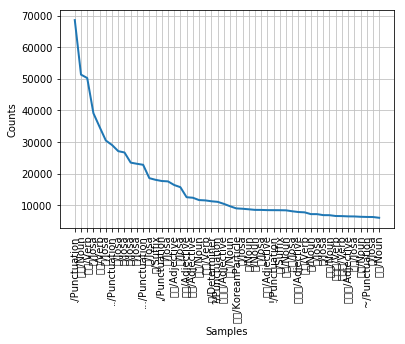

In [19]:
text.plot(50)

한글이 깨진다.

In [21]:
from matplotlib import font_manager, rc

font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

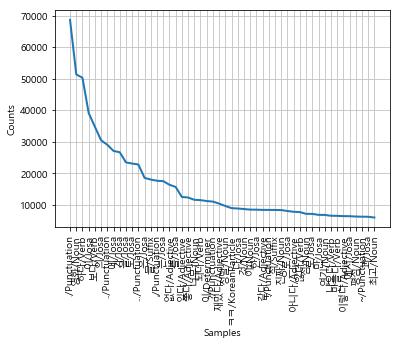

In [31]:
text.plot(50)

## Sentiment classification with term-existance
* 아래는 term이 문서에 존재하는지의 유무에 따라 분류를 해본다.

최빈도 단어 200개를 피쳐로 사용

In [ ]:
selected_words = [f[0] for f in text.vocab().most_common(200)]

def term_exists(doc):
    return{'exists({})'.format(word): (word in set(doc)) for word in selected_words}

# 시간 